In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL
import pandas as pd

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, True)
])
shape_record = {0: [(1, 2049)]}

In [3]:
kb_size = 20
train_size = 140

In [4]:
filename = '../ZSTL_Data/Animals_with_Attributes2/splitedTask/task_train_data_standard.pickle'
filename = '../ZSTL_Data/CUB_200_2011/CUB_200_2011/splitedTask/task_train_data_standard.pickle'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
print(len(dataset), len(list(dataset.keys())))
print(type(dataset))

total_len = len(dataset)
test_size = total_len - kb_size - train_size


# filename = '../ZSTL_Data/Animals_with_Attributes2/splitedTask/task_train_data_bin.pickle'
# with open(filename, 'rb') as f:
#     dataset = pickle.load(f)
# print(len(dataset), len(list(dataset.keys())))
# print(type(dataset))


200 200
<class 'dict'>


In [5]:
#check stored data correctness
def check_attr_correct(num_task, dataset, task_attr_byID, model):
    task_train_data = {}
    task_test_data = {}
    task_val_data = {}
    for t in range(num_task):
        cur_attr = dataset[t+1][0]
        cur_param = utils.toTensor(dataset[t+1][1])
        cur_x = utils.toTensor(dataset[t+1][2])
        cur_y = dataset[t+1][3]
        print((cur_attr==task_attr_byID[t+1]).all())


        reshaped_w = utils.reshape_w(cur_param, shape_record)
        pred = model(reshaped_w, cur_x)
        pred = torch.sigmoid(pred)
        pred[pred>=0.5] = torch.ones_like(pred[pred>=0.5])
        pred[pred<0.5] = torch.zeros_like(pred[pred<0.5])
        print(np.sum(utils.toNumpy(pred)==cur_y)/100)



In [6]:
path_attributes = '../ZSTL_Data/Animals_with_Attributes2/predicate-matrix-continuous.txt'
def gen_attr(path_attributes):
    data_attributes = pd.read_csv(path_attributes, sep="\n", header=None)
    print(data_attributes)
    lst = []
    task_attr_byID = {}
    i = 1
    for r in data_attributes.iterrows():
        # print(len(r), )
        s = r[1].to_numpy()
        # print(len(s[0].split()), s[0].split())
        print(len(s[0].split()))
        task_attr_byID[i] = np.array([float(a) for a in s[0].split()])
        print(task_attr_byID[i].shape)
        i += 1
    return task_attr_byID

#task_attr_byID = gen_attr(path_attributes)



In [7]:
#check_attr_correct(total_len, dataset, task_attr_byID, net)

In [8]:
indx = [ x+1 for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

20
130
50


In [9]:
support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([20, 1, 312]) torch.Size([20, 1, 2049]) torch.Size([20, 60, 2049]) torch.Size([20, 60, 1])


In [18]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
d = support_w.size()[0]
print(d, dm)

param_dict = {}
param_dict['rho'] = 0.00001
param_dict['mu'] = 0.00001
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'


ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)

2049 312


init mean test metric 0.6573333333333333;
1/800 o_loss 0.6579872171036326; m train metric 0.5024358974358973; m test metric 0.5073333333333333; align loss  0.12377285957336426
10/800 o_loss 0.672609130346861; m train metric 0.5719230769230765; m test metric 0.566; align loss  0.10472580790519714
20/800 o_loss 0.6541382722341671; m train metric 0.6310256410256411; m test metric 0.6403333333333334; align loss  0.0851258784532547
30/800 o_loss 0.6509421565928138; m train metric 0.6629487179487181; m test metric 0.6593333333333332; align loss  0.0684380754828453
40/800 o_loss 0.6490155974868685; m train metric 0.6779487179487178; m test metric 0.6696666666666664; align loss  0.053794704377651215
50/800 o_loss 0.6476996887117051; m train metric 0.6791025641025641; m test metric 0.6626666666666666; align loss  0.04323823004961014
60/800 o_loss 0.6459285805610797; m train metric 0.6860256410256411; m test metric 0.664; align loss  0.03619077429175377
70/800 o_loss 0.6447790041422614; m train 

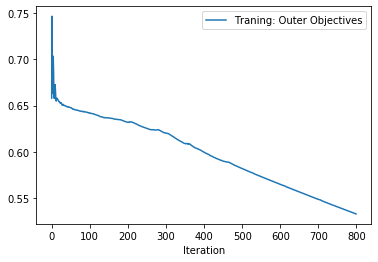

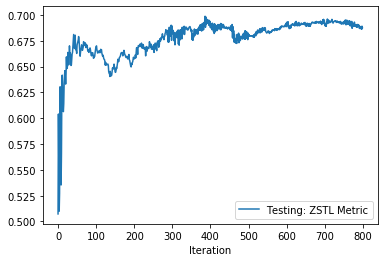

0

In [19]:
ZSTL_model.train(train_loader, test_loader, max_iter=800)

In [12]:
print(ZSTL_model.a_kb_opt.shape)

torch.Size([312, 20])
